In [1]:
import sys
import os
from ml4cvd.arguments import parse_args
from ml4cvd.recipes import run
import h5py
import numpy as np
import matplotlib
# font = {'family' : 'Arial',
#         'size'   : 30}
# matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
from typing import List, Dict, Callable
from collections import defaultdict
import pandas as pd

from ml4cvd.arguments import _get_tmap
from ml4cvd.TensorMap import TensorMap
from ml4cvd.tensor_from_file import TMAPS

import numpy as np
USER = 'pdiachil'
HOME_PATH = '/home/' + USER

In [ ]:
# sys.argv = ['tensorize',
#             '--mode', 'tensorize_ludb',
#             '--xml_folder', f'{HOME_PATH}/ludb/',
#             '--output_folder', f'{HOME_PATH}/ludb_tensors/',
#             '--tensors', f'{HOME_PATH}/ludb_tensors/',
#             '--min_sample_id', '1', 
#             '--max_sample_id', '201'
#            ]
# args = parse_args()
# run(args)

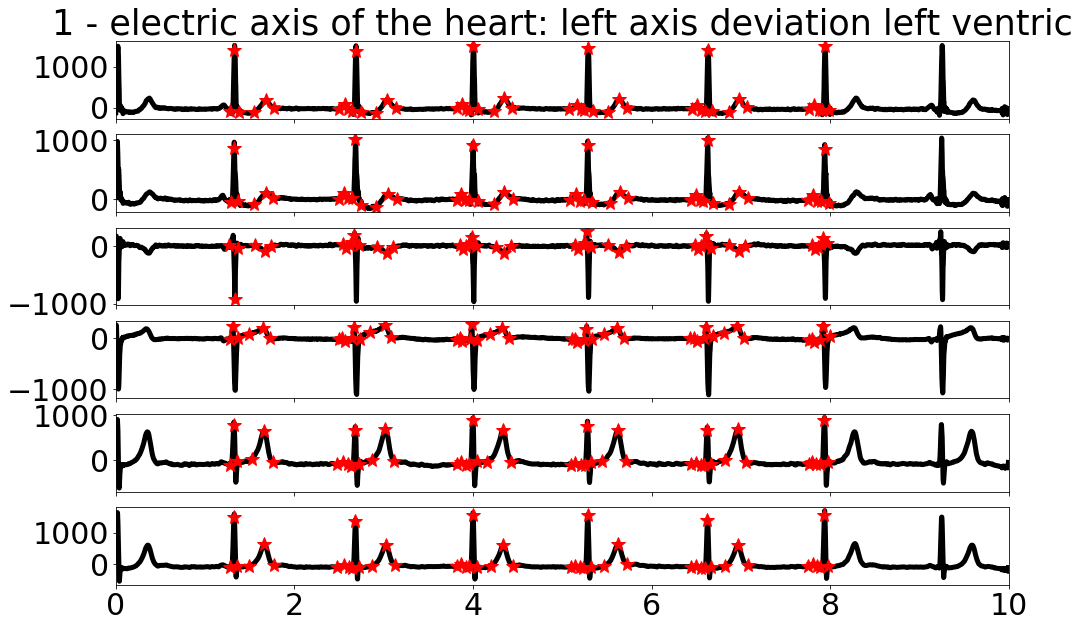

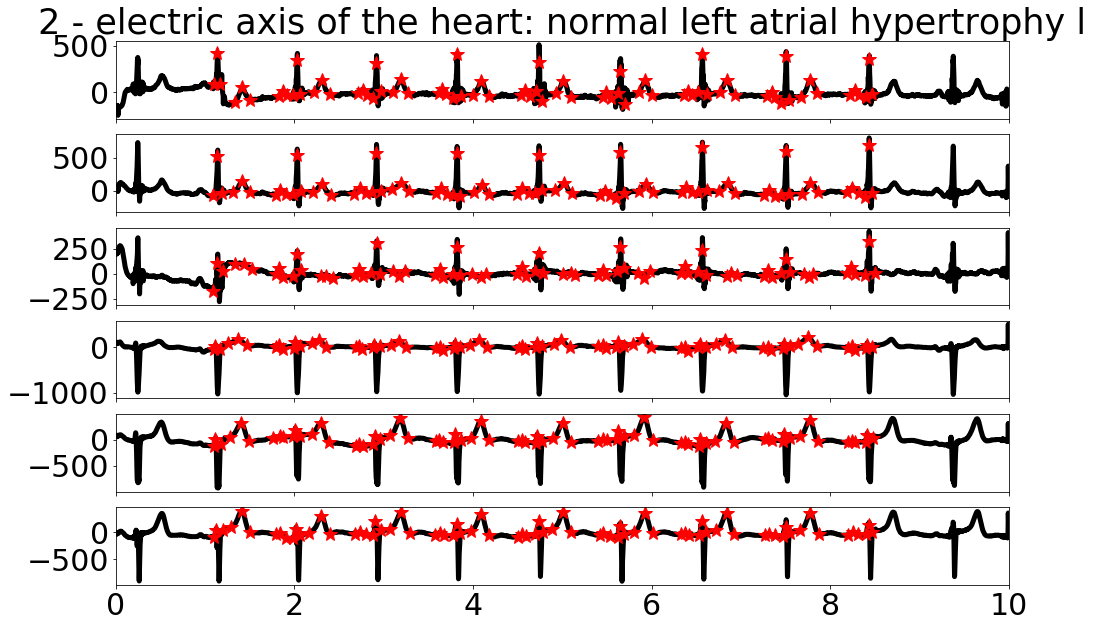

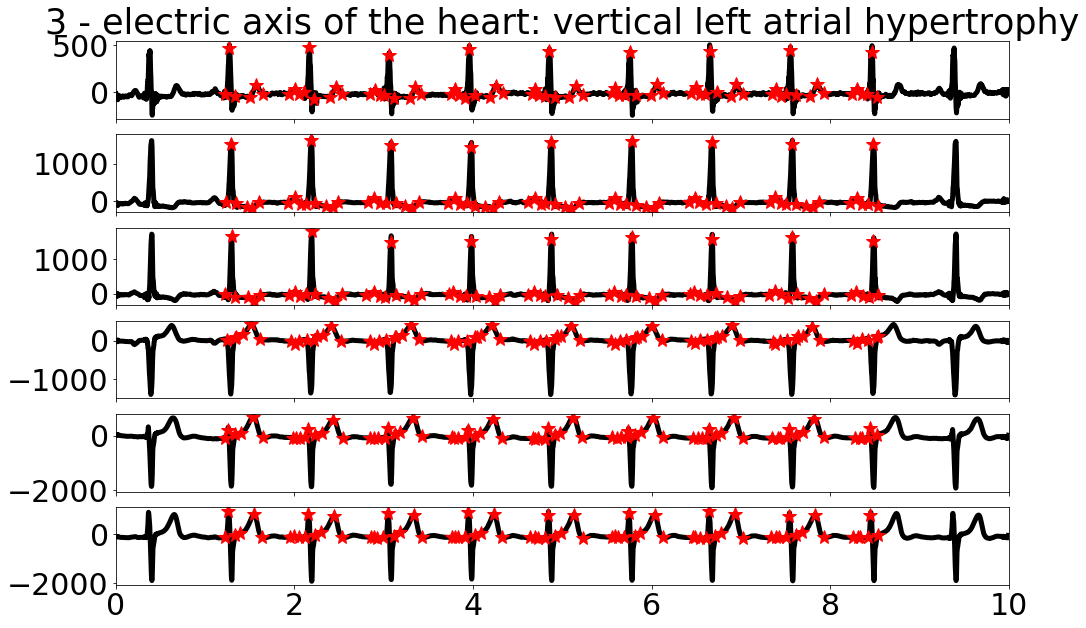

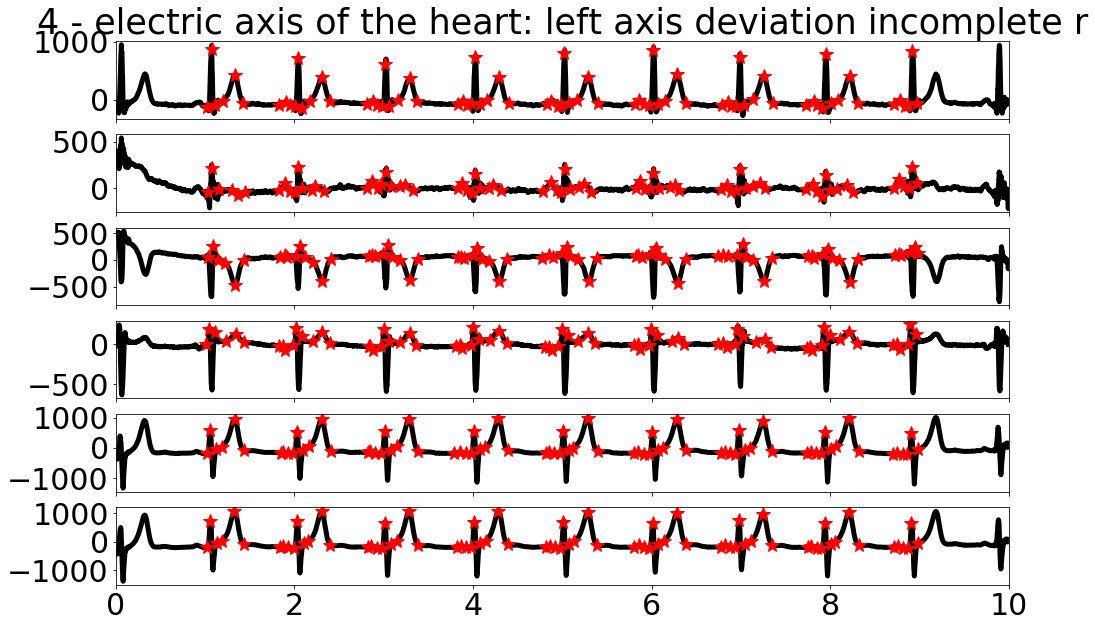

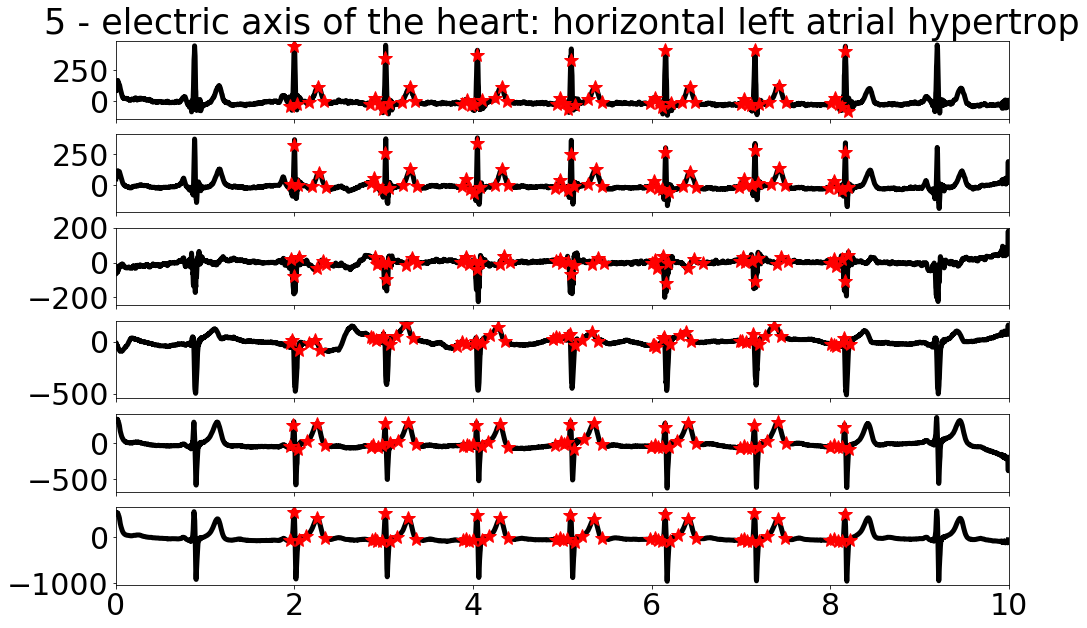

In [4]:
%matplotlib inline

ECG_REST_LUDB_LEADS =  {'i': 0, 'ii': 1, 'iii': 2, 'v1': 3, 'v2': 4, 'v3': 5,
                        'v4': 6, 'v5': 7, 'v6': 8, 'avf': 9, 'avl': 10, 'avr': 11}
ECG_REST_LUDB_LEADS =  {'i': 0, 'ii': 1, 'iii': 2, 'v1': 3, 'v2': 4, 'v3': 5}

for i in range(1, 200):
    with h5py.File(f'{HOME_PATH}/workspace/p/projects/2020_02_ecg_segmentation/ludb_tensors/{i}.hd5', 'r') as hd5:
        f, ax = plt.subplots(len(ECG_REST_LUDB_LEADS), 1)
        f.set_size_inches(16, 10)
        for lead in ECG_REST_LUDB_LEADS:
            ann = np.array(hd5[f'ecg_rest_annotation/annotation_{lead}'])
            data = np.array(hd5[f'ecg_rest/strip_{lead}'])
            ax[ECG_REST_LUDB_LEADS[lead]].plot(data, 'k', linewidth=5)
            ax[ECG_REST_LUDB_LEADS[lead]].plot(ann, data[ann], 'r*', markersize=15)
            ax[ECG_REST_LUDB_LEADS[lead]].set_xticklabels([])
            ax[ECG_REST_LUDB_LEADS[lead]].set_xticks([0, 1000, 2000, 3000, 4000, 5000])
            ax[ECG_REST_LUDB_LEADS[lead]].set_xlim([0, 5000])
            ax[ECG_REST_LUDB_LEADS[lead]].tick_params(labelsize=30)
        ax[ECG_REST_LUDB_LEADS[lead]].set_xticklabels(['0', '2', '4', '6', '8', '10'])
        ax[0].set_title(str(i) + ' - ' + hd5['ecg_rest_text'][()][0][:60], size=35)
        plt.tight_layout
        f.savefig(f'/home/pdiachil/workspace/p/projects/2020_02_ecg_segmentation/ludb_output/annotation_ludb_{i}.png')
    if i == 5:
        break

In [5]:
def annotation_to_segmentation(data, ann, shape = (5000,)):
    cycle = ['QR', 'RS', 'ST1', 'T1T2', 'T2T3', 'T3P1', 'P1P2', 'P2P3', 'P3Q']
    parsed_data = np.zeros(shape)
    parsed_range = ann[-1] - ann[0]
    parsed_data[:parsed_range] = data[ann[0]:ann[-1]]
    segmented_data = np.zeros(shape, dtype=np.int)
    ic = 0
    for ia in range(len(ann)-1):
        segmented_data[ann[ia]-ann[0]:ann[ia+1]-ann[0]] = ic
        ic += 1
        if ic == len(cycle):
            ic = 0
    return parsed_data, segmented_data      

In [ ]:
import matplotlib

segments = {0 : 'background', 1: 'qrs', 2: 'st', 3: 't', 4: 'tp', 5: 'p', 6: 'pq'}
colors = {'background': 'black', 'qrs': 'red', 'st': 'blue', 't': 'cyan', 'tp': 'magenta', 'p': 'green', 'pq': 'yellow'}

cmap = matplotlib.cm.get_cmap('Pastel1')
cmap_float = np.linspace(0.0, 1.0, 7)

colors = {'background': cmap(cmap_float[0]), 'qrs': cmap(cmap_float[1]), 'st': cmap(cmap_float[2]), 't': cmap(cmap_float[3]), 
          'tp': cmap(cmap_float[4]), 'p': cmap(cmap_float[5]), 'pq': cmap(cmap_float[6])}

def plot_segmented_ecg(input_tensor, output_tensor):
    for ecg in range(input_tensor.shape[0]):
        f, ax = plt.subplots(8,1)
        f.set_size_inches(16, 9)           
        
        for lead in range(input_tensor.shape[2]):
            ax[lead].plot(input_tensor[ecg, :, lead, 0])
            ax[lead].set_xlim([0, input_tensor.shape[1]])
            segmented = np.argmax(output_tensor[ecg, :, lead, :], axis=1) 
            change_indices = np.where(segmented[:-1] != segmented[1:])[0]
            previous_change_index = 0
            for change_index in change_indices:
                ax[lead].axvspan(previous_change_index, change_index, 
                                 facecolor=colors[segments[segmented[change_index]]],
                                 alpha=1.0)
                previous_change_index = change_index
                previous_segment = segmented[previous_change_index]                                 
        break

In [ ]:
import glob
from matplotlib import cm
hd5_paths = glob.glob(f'{HOME_PATH}/ludb_tensors/*.hd5')
for hd5_path in hd5_paths:
    with h5py.File(hd5_path, 'r') as hd5:        
        ann = np.array(hd5['ecg_rest_annotation/annotation_i'])
        data = np.array(hd5['ecg_rest/strip_i'])
        parsed, segmented = annotation_to_segmentation(data, ann)
        f, ax = plt.subplots()
        f.set_size_inches(16, 4)
        ax.scatter(range(len(parsed)), parsed, c=cm.hot(segmented/8.0))
        ax.set_title(hd5_path)
        
    break

In [ ]:
import glob
from ml4cvd.arguments import _get_tmap
hd5_paths = glob.glob(f'{HOME_PATH}/ludb_tensors/*.hd5')
tm_data = _get_tmap('ecg_rest_ludb')
tm_segmentation = _get_tmap('ecg_rest_ludb_segmentation_weighted')
for hd5_path in hd5_paths:
    with h5py.File(hd5_path, 'r') as hd5:
        data = tm_data.tensor_from_file(tm_data, hd5)
        segmentation = tm_segmentation.tensor_from_file(tm_segmentation, hd5)
    break

In [ ]:
# sys.argv = ['train',
#             '--mode', 'train',
#             '--output_folder', f'{HOME_PATH}/ludb_output/',
#             '--tensors', f'{HOME_PATH}/ludb_tensors/',
#             '--input_tensors', 'ecg_rest_ludb',
#             '--output_tensors', 'ecg_rest_ludb_segmentation_coarse',
#             '--id', 'test_ludb_segmentation_unet',
#             '--num_workers', '0',
#             '--u_connect',
#             '--inspect_model',
#             '--training_steps', '14',
#             '--validation_steps', '2',
#             '--test_steps', '2',
#             '--batch_size', '4',
#             '--epochs', '100'
#            ]
# args = parse_args()
# run(args)

In [ ]:
def tmaps_by_sample_id(tensor_folder: str, sample_id: str, tmaps: List[TensorMap], dependent_tmap):
    path = os.path.join(tensor_folder, sample_id + '.hd5')
    result_dict = defaultdict(lambda: None)
    dependents = defaultdict(lambda: None)
    if os.path.isfile(path):
            with h5py.File(path, 'r') as hd5:
                for tmap in tmaps:
                    try:
                        result_dict[tmap] = tmap.tensor_from_file(tmap, hd5, dependents)
                        for dependent in dependents:
                            result_dict[dependent] = np.array(dependents[dependent])
                    except (IndexError, KeyError, ValueError, OSError, RuntimeError):
                        continue
    return result_dict


def tmaps_with_properties(tensor_folder: str, tmap_properties: Dict[TensorMap, Callable[[np.ndarray], bool]], search_size=100, dependent_tmap=None):
    all_ids = [file.strip('.hd5') for file in sorted(os.listdir(tensor_folder))[:search_size]]
    results = map(lambda sample_id: tmaps_by_sample_id(tensor_folder, sample_id, tmap_properties.keys(), dependent_tmap), all_ids)
    return {
        sample_id: result
        for sample_id, result in zip(all_ids, results)
        if all(
            result[tmap] is not None and tmap_properties[tmap](result[tmap])
            for tmap in tmap_properties.keys()
        )
    }


def tmaps_with_properties_from_keys(tensor_folder: str, tmap_properties: Dict[str, Callable[[np.ndarray], bool]], search_size=100, dependent_tmap=None):
    return tmaps_with_properties(
        tensor_folder,
        {_get_tmap(key): prop for key, prop in tmap_properties.items()},
        search_size, dependent_tmap
    )

def tmap_dic_to_dic(tmap_dic):
    sample_id = []
    tmaps = []
    tmap_names = []
    tmap_subcols = []
    out_dic = {'sample_id': []}
        
    for i, entry in enumerate(tmap_dic):
        for t in tmap_dic[entry]:
            nsubcols = np.prod(t.shape)
            for n in range(nsubcols):
                out_dic[t.name + '_' + str(n)] = np.zeros(len(tmap_dic))
        break
    
    for i, entry in enumerate(tmap_dic):
        out_dic['sample_id'].append(entry)
        for t in tmap_dic[entry]:   
            nsubcols = np.prod(t.shape)
            for n in range(nsubcols):
                out_dic[t.name + '_' + str(n)][i] = tmap_dic[entry][t].ravel()[n]
    return out_dic

In [ ]:
a = tmaps_by_sample_id('/home/pdiachil/ludb_tensors/', '1', [_get_tmap('ecg_rest_ludb')], _get_tmap('ecg_rest_ludb_segmentation_coarse'))

b = tmaps_with_properties_from_keys(
    '/home/pdiachil/ludb_tensors/', 
    {
        'ecg_rest_ludb': lambda x: True,
    },
    search_size = 20,
    dependent_tmap = _get_tmap('ecg_rest_ludb_segmentation_coarse')
)

In [ ]:
dd = tmap_dic_to_dic(b)
df = pd.DataFrame(dd)
df

In [ ]:
# cols = [f'ecg_rest_ludb_segmentation_{i}' for i in range(0, 40000, 2)]
# df[cols].apply(pd.Series.value_counts)

In [ ]:
# 2900000.0 / df[cols].apply(pd.Series.value_counts).sum(axis=1)/20.390944

In [ ]:
sys.argv = ['train',
            '--mode', 'train',
            '--output_folder', f'{HOME_PATH}/ludb_output/',
            '--tensors', f'{HOME_PATH}/ludb_tensors/',
            '--input_tensors', 'ecg_rest_ludb',
            '--output_tensors', 'ecg_rest_ludb_segmentation_coarse',
            '--id', 'test_ludb_coarse_segmentation_no3d',
            '--num_workers', '0',
            '--u_connect', 
            '--inspect_model',
            '--training_steps', '15',
            '--validation_steps', '5',
            '--test_steps', '5',
            '--batch_size', '8',
            '--epochs', '400',
            '--patience', '40'            
           ]
args = parse_args()
run(args)

In [ ]:
b = tmaps_with_properties_from_keys(
    '/mnt/disks/ecg-rest-37k-tensors/2019-11-04/', 
    {
        'ecg_rest_random_lead': lambda x: True,
    },
    search_size = 20,
    dependent_tmap = _get_tmap('ecg_lead_detection')
)
dd = tmap_dic_to_dic(b)
df = pd.DataFrame(dd)
df

# Infer segmentation on rest

In [ ]:
from ml4cvd.models import make_multimodal_multitask_model
from ml4cvd.tensor_generators import test_train_valid_tensor_generators
sys.argv = ['train',
            '--mode', 'train',
            '--output_folder', f'{HOME_PATH}/ukbb_output/',
            '--tensors', f'/home/pdiachil/ludb_tensors/',
            '--test_modulo', '0',
            '--num_workers', '0',
            '--valid_ratio', '0.0001',
            '--test_ratio', '0.0001',
            '--batch_size', '1',
            '--input_tensors', 'ecg_rest_ludb',
            '--output_tensors', 'ecg_rest_ludb_segmentation_coarse',
            '--model_file', f'{HOME_PATH}/ludb_output/test_ludb_coarse_segmentation_roll_scale_shift_bylead/test_ludb_coarse_segmentation_roll_scale_shift_bylead.hd5',
            '--id', 'ludb_coarse_segmentation_roll_scale_inferred_on_ecg_rest'
           ]
args = parse_args()
model = make_multimodal_multitask_model(**args.__dict__)
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)

In [ ]:
import matplotlib

segments = {0 : 'background', 1: 'qrs', 2: 'st', 3: 't', 4: 'tp', 5: 'p', 6: 'pq'}
colors = {'background': 'black', 'qrs': 'red', 'st': 'blue', 't': 'cyan', 'tp': 'magenta', 'p': 'green', 'pq': 'yellow'}

cmap = matplotlib.cm.get_cmap('Pastel1')
cmap_float = np.linspace(0.0, 1.0, 7)

colors = {'background': cmap(cmap_float[0]), 'qrs': cmap(cmap_float[1]), 'st': cmap(cmap_float[2]), 't': cmap(cmap_float[3]), 
          'tp': cmap(cmap_float[4]), 'p': cmap(cmap_float[5]), 'pq': cmap(cmap_float[6])}

def plot_segmented_ecg(input_tensor, output_tensor):
    for ecg in range(input_tensor.shape[0]):
        f, ax = plt.subplots(8,1)
        f.set_size_inches(16, 12)           
        
        for lead in range(input_tensor.shape[2]):
            ax[lead].plot(input_tensor[ecg, :, lead, 0], linewidth=3)
            ax[lead].set_xlim([0, input_tensor.shape[1]])
            ax[lead].tick_params(labelsize=25)
            ax[lead].set_xticklabels([])
            ax[lead].set_yticklabels([])
            segmented = np.argmax(output_tensor[ecg, :, lead, :], axis=1) 
            change_indices = np.where(segmented[:-1] != segmented[1:])[0]
            previous_change_index = 0
            for change_index in change_indices:
                ax[lead].axvspan(previous_change_index, change_index, 
                                 facecolor=colors[segments[segmented[change_index]]],
                                 alpha=1.0)
                previous_change_index = change_index
                previous_segment = segmented[previous_change_index]    
        f.savefig('/home/pdiachil/')
        break

In [ ]:
for i in range(10):
    a, b = next(generate_train)
    input_tensor = a['input_ecg_rest_ludb_ecg_rest_ludb'].reshape((1, 5000, -1, 1))
    output_tensor = model.predict(input_tensor)
    plot_segmented_ecg(input_tensor, output_tensor)

In [ ]:
# from ml4cvd.models import make_multimodal_multitask_model
# from ml4cvd.tensor_generators import test_train_valid_tensor_generators
# sys.argv = ['train',
#             '--mode', 'train',
#             '--output_folder', f'{HOME_PATH}/ukbb_output/',
#             '--tensors', f'/mnt/disks/ecg-rest-37k-tensors/2019-11-04/',
#             '--test_modulo', '0',
#             '--num_workers', '0',
#             '--valid_ratio', '0.0001',
#             '--test_ratio', '0.0001',
#             '--batch_size', '1',
#             '--input_tensors', 'ecg_rest',
#             '--output_tensors', 'ecg_rest_ludb_segmentation_coarse',
#             '--model_file', f'{HOME_PATH}/ludb_output/test_ludb_coarse_segmentation_roll_scale_shift_bylead/test_ludb_coarse_segmentation_roll_scale_shift_bylead.hd5',
#             '--id', 'ludb_coarse_segmentation_roll_scale_inferred_on_ecg_rest'
#            ]
# args = parse_args()
# model = make_multimodal_multitask_model(**args.__dict__)
# generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(**args.__dict__)

In [ ]:
for i in range(20):
    a, b = next(generate_train)
    input_tensor = a['input_strip_ecg_rest'].reshape((1, 5000, -1, 1))
    output_tensor = model.predict(input_tensor)
    plot_segmented_ecg(input_tensor, output_tensor)

# Interval predictions for pretraining

In [ ]:
# sys.argv = ['train',
#             '--mode', 'train',
#             '--output_folder', f'{HOME_PATH}/ukbb_output/',
#             '--tensors', f'/mnt/disks/ecg-rest-37k-tensors/2019-11-04/',
#             '--input_tensors', 'ecg_rest',
#             '--output_tensors', 'ventricular-rate', 'qrs-duration', 'pp-interval', 'pq-interval', 'p-duration',
#             'qt-interval',
#             '--id', 'ecg_lead_detection_raw',
#             '--inspect_model',
#             '--training_steps', '810',
#             '--validation_steps', '115',
#             '--conv_z', '2',
#             '--test_steps', '230',
#             '--batch_size', '32',
#             '--epochs', '50',
#             '--patience', '12'            
#            ]
# args = parse_args()
# run(args)

# Lead detection

In [ ]:
# sys.argv = ['train',
#             '--mode', 'train',
#             '--output_folder', f'{HOME_PATH}/ukbb_output/',
#             '--tensors', f'/mnt/disks/ecg-rest-37k-tensors/2019-11-04/',
#             '--input_tensors', 'ecg_rest_random_lead',
#             '--output_tensors', 'ecg_lead_detection',
#             '--id', 'ecg_lead_detection_raw',
#             '--inspect_model',
#             '--training_steps', '810',
#             '--validation_steps', '115',
#             '--conv_z', '2',
#             '--test_steps', '230',
#             '--batch_size', '32',
#             '--epochs', '50',
#             '--patience', '12'            
#            ]
# args = parse_args()
# run(args)

# Segmentation 2.5s

In [ ]:
sys.argv = ['train',
            '--mode', 'train',
            '--output_folder', f'{HOME_PATH}/ukbb_output/',
            '--tensors', f'/mnt/disks/ecg-rest-37k-tensors/2019-11-04/',
            '--input_tensors', 'ecg_rest_random_lead',
            '--output_tensors', 'ecg_lead_detection',
            '--id', 'ecg_lead_detection_raw',
            '--inspect_model',
            '--training_steps', '810',
            '--validation_steps', '115',
            '--conv_z', '2',
            '--test_steps', '230',
            '--batch_size', '32',
            '--epochs', '50',
            '--patience', '12'            
           ]
args = parse_args()